In [58]:
import rasterio as rio
from rasterio.plot import show
from PIL import Image
import torch
import pandas as pd
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

import shutil, random, os
import sys
sys.path.append('../../SimCLR_SLICE/')

from data_utils import get_dataset_from_name
from model import load_state_dict_subset
from models.utils import get_model_from_name, simclr_resnet_models
from simclr import SimCLR
from simclr.modules import LogisticRegression, get_resnet
from simclr.modules.transformations import TransformsSimCLR
from simclr.modules.resnet_hacks import modify_resnet_model

In [3]:
%matplotlib inline

In [4]:
seed = 42
random.seed(seed)

n_files = 5000 # 5000 from each region
image_dir_med = Path('/scratch/08452/kaipak/datasets/gee_sar_100k_reference_v1.0.0523/train/linear/images/mediterranean')
image_dir_cal = Path('/scratch/08452/kaipak/datasets/gee_sar_100k_reference_v1.0.0523/train/linear/images/california')

In [ ]:
images_cal = pd.Series([os.path.join(image_dir_cal, img_file_name) 
                        for img_file_name in random.sample(os.listdir(image_dir_cal), n_files)])
images_med = pd.Series([os.path.join(image_dir_med, img_file_name) 
                        for img_file_name in random.sample(os.listdir(image_dir_med), n_files)])

In [ ]:
##images_cal.to_csv('/scratch/08452/kaipak/datasets/gee_sar_100k_reference_v1.0.0523/rand_5k_unlabeled_cal.csv', index=False, header=False)
##images_med.to_csv('/scratch/08452/kaipak/datasets/gee_sar_100k_reference_v1.0.0523/rand_5k_unlabeled_med.csv', index=False, header=False)

In [ ]:
images_cal.head()

## Combine Results with Imagelist
Throwaway the labels as they are just all -1 so the code will process the file. 


In [5]:
cal_imgs_file = Path('/scratch/08452/kaipak/datasets/gee_sar_100k_reference_v1.0.0523/rand_5k_unlabeled_cal.csv')
cal_pred_file = Path('/work/08452/kaipak/ls6/dev/linear_evaluation/preds_cal.out')
med_imgs_file = Path('/scratch/08452/kaipak/datasets/gee_sar_100k_reference_v1.0.0523/rand_5k_unlabeled_med.csv')
med_pred_file = Path('/work/08452/kaipak/ls6/dev/linear_evaluation/preds_med.out')

img_med = pd.read_csv(med_imgs_file)['image']
res_med = pd.read_csv(med_pred_file, header=None).squeeze("columns")
df_med_inf_res = pd.DataFrame({"image": img_med, "label": res_med})

img_cal = pd.read_csv(cal_imgs_file)['image']
res_cal = pd.read_csv(cal_pred_file, header=None).squeeze("columns")
df_cal_inf_res = pd.DataFrame({"image": img_cal, "label": res_cal})

In [6]:
df_med_inf_res

,image,label
0,train/linear/images/mediterranean/S1A_IW_GRDH_...,0
1,train/linear/images/mediterranean/S1A_IW_GRDH_...,0
2,train/linear/images/mediterranean/S1A_IW_GRDH_...,0
3,train/linear/images/mediterranean/S1A_IW_GRDH_...,0
4,train/linear/images/mediterranean/S1A_IW_GRDH_...,0
...,...,...
4995,train/linear/images/mediterranean/S1A_IW_GRDH_...,0
4996,train/linear/images/mediterranean/S1A_IW_GRDH_...,0
4997,train/linear/images/mediterranean/S1A_IW_GRDH_...,0
4998,train/linear/images/mediterranean/S1A_IW_GRDH_...,0


In [10]:
df_cal_inf_res.groupby(by='label').size()

label
0    4825
1     175
dtype: int64

In [11]:
df_med_inf_res.groupby(by='label').size()

label
0    4712
1     288
dtype: int64

In [177]:
# Copy images to output folders
img_root = Path('/scratch/08452/kaipak/datasets/gee_sar_100k_reference_v1.0.0523')
dest_root = Path('/home1/08452/kaipak/simclr_inference_results_062923/')


def process_res(df_preds, locale):
    """ Process images in results dataframe, convert to jpeg, then place in appropriate directory """
    
    for i, row in df_preds.iterrows():
        img_scaled = scale_img(os.path.join(img_root, row.image))
        plt.axis('off')
        plt.imshow(img_scaled, cmap='gray', vmin=0, vmax=1)
        
        if row.label == 0:    
            plt.savefig(
                os.path.join(dest_root, locale, 'neg', os.path.basename(row.image)), bbox_inches="tight"
            )
        else:
            plt.savefig(
                os.path.join(dest_root, locale, 'pos', os.path.basename(row.image)), bbox_inches="tight"
            )
        plt.close()
        
        if i % 100 == 0:
            print(f"completed {i}/{df_preds.shape[0]}")
        



def scale_img(img_file):
    img = rio.open(img_file).read(1)
    min_, max_ = img[img > 0].min(), img.max()
    arr = (img - min_) / (max_ - min_)
    # use mean of 0.5
    scale_factor = 0.5 / img[img > 0].mean()
    img = img * scale_factor
    img[img < 0] = -0.1
    
    return img
                        
def display_img(img) -> None:
    plt.imshow(img, cmap='gray', vmin=0, vmax=1)

In [74]:
df_med_inf_res[df_med_inf_res.label == 1].iloc[np.random.randint(170), 0]

'train/linear/images/mediterranean/S1A_IW_GRDH_1SDV_20160604T170343_20160604T170408_011564_011A8B_9856_VV_58908.tif'

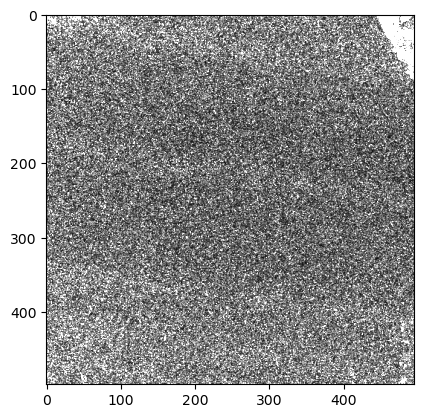

In [175]:
rand_img = scale_img(
    os.path.join(img_root, df_med_inf_res[df_med_inf_res.label == 1].iloc[np.random.randint(288), 0])
)
display_img(rand_img)

In [179]:
process_res(df_med_inf_res, 'med')

completed 0/5000
completed 100/5000
completed 200/5000
completed 300/5000
completed 400/5000
completed 500/5000
completed 600/5000
completed 700/5000
completed 800/5000
completed 900/5000
completed 1000/5000
completed 1100/5000
completed 1200/5000
completed 1300/5000
completed 1400/5000
completed 1500/5000
completed 1600/5000
completed 1700/5000
completed 1800/5000
completed 1900/5000
completed 2000/5000
completed 2100/5000
completed 2200/5000
completed 2300/5000
completed 2400/5000
completed 2500/5000
completed 2600/5000
completed 2700/5000
completed 2800/5000
completed 2900/5000
completed 3000/5000
completed 3100/5000
completed 3200/5000
completed 3300/5000
completed 3400/5000
completed 3500/5000
completed 3600/5000
completed 3700/5000
completed 3800/5000
completed 3900/5000
completed 4000/5000
completed 4100/5000
completed 4200/5000
completed 4300/5000
completed 4400/5000
completed 4500/5000
completed 4600/5000
completed 4700/5000
completed 4800/5000
completed 4900/5000


In [181]:
process_res(df_cal_inf_res, 'cal')

completed 0/5000
completed 100/5000
completed 200/5000
completed 300/5000
completed 400/5000
completed 500/5000
completed 600/5000
completed 700/5000
completed 800/5000
completed 900/5000
completed 1000/5000
completed 1100/5000
completed 1200/5000
completed 1300/5000
completed 1400/5000
completed 1500/5000
completed 1600/5000
completed 1700/5000
completed 1800/5000
completed 1900/5000
completed 2000/5000
completed 2100/5000
completed 2200/5000
completed 2300/5000
completed 2400/5000
completed 2500/5000
completed 2600/5000
completed 2700/5000
completed 2800/5000
completed 2900/5000
completed 3000/5000
completed 3100/5000
completed 3200/5000
completed 3300/5000
completed 3400/5000
completed 3500/5000
completed 3600/5000
completed 3700/5000
completed 3800/5000
completed 3900/5000
completed 4000/5000
completed 4100/5000
completed 4200/5000
completed 4300/5000
completed 4400/5000
completed 4500/5000
completed 4600/5000
completed 4700/5000
completed 4800/5000
completed 4900/5000
